<a href="https://colab.research.google.com/github/adiazoq/Proyecto-Machine-Learning/blob/main/C%C3%B3digos/MODELO_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cargar los paquetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Para ignorar algunos warnings que podrían aparecer
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Leer base de datos de excel
from google.colab import files
uploaded = files.upload()
!ls

Saving df_diario_promediado.xlsx to df_diario_promediado.xlsx
df_diario_promediado.xlsx  sample_data


In [ ]:
# 1. Cargar y preparar los datos
# Asumiendo que tu archivo está en formato Excel y tiene columnas 'Dia' y 'TemperaturaPromedio'
df = pd.read_excel("df_diario_promediado.xlsx")

In [ ]:
# Convertir columna de fecha
# Si viene como número de Excel, usar:
# df['Dia'] = pd.to_datetime(df['Dia'], unit='d', origin='1899-12-30')
# Si ya es fecha:
df['Dia'] = pd.to_datetime(df['Dia'])

# Verificar datos
print("Primeras filas:")
print(df.head())
print("\nResumen de TemperaturaPromedio:")
print(df['TemperaturaPromedio'].describe())
print(f"\nRango de fechas: {df['Dia'].min()} a {df['Dia'].max()}")


Primeras filas:
         Dia  TemperaturaPromedio   Año   NombreEstacion CodigoEstacion  \
0 2006-01-01            27.579167  2006  FEDEARROZ - AUT       28035060   
1 2006-01-02            27.875000  2006  FEDEARROZ - AUT       28035060   
2 2006-01-03            27.754167  2006  FEDEARROZ - AUT       28035060   
3 2006-01-04            26.141667  2006  FEDEARROZ - AUT       28035060   
4 2006-01-05            26.841667  2006  FEDEARROZ - AUT       28035060   

  CodigoSensor  
0           68  
1           68  
2           68  
3           68  
4           68  

Resumen de TemperaturaPromedio:
count    6747.000000
mean       28.265851
std         2.110913
min        18.878261
25%        26.926875
50%        28.412500
75%        29.680760
max        36.266667
Name: TemperaturaPromedio, dtype: float64

Rango de fechas: 2006-01-01 00:00:00 a 2024-12-31 00:00:00


In [ ]:
# ============================================
# 2. CREAR SERIE TEMPORAL SEMANAL
# ============================================

# Convertir a serie semanal
df['Semana'] = df['Dia'].dt.to_period('W').dt.start_time
df_semanal = df.groupby('Semana')['TemperaturaPromedio'].mean().reset_index()
df_semanal = df_semanal.rename(columns={'TemperaturaPromedio': 'Temperatura'})

# Crear serie temporal con frecuencia 52 (semanas por año)
# En Python no usamos directamente ts objects como en R
# Usaremos DataFrames con índices temporales
df_semanal.set_index('Semana', inplace=True)


In [ ]:
# ============================================
# 3. DIVIDIR DATOS (hasta 2020)
# ============================================

# Dividir en entrenamiento (hasta 2020) y prueba (2021-2024)
train_df = df_semanal[df_semanal.index < '2021-01-01']
test_df = df_semanal[df_semanal.index >= '2021-01-01']

print(f"Entrenamiento: {len(train_df)} semanas (2006-2020)")
print(f"Prueba: {len(test_df)} semanas (2021-2024)")


Entrenamiento: 783 semanas (2006-2020)
Prueba: 202 semanas (2021-2024)


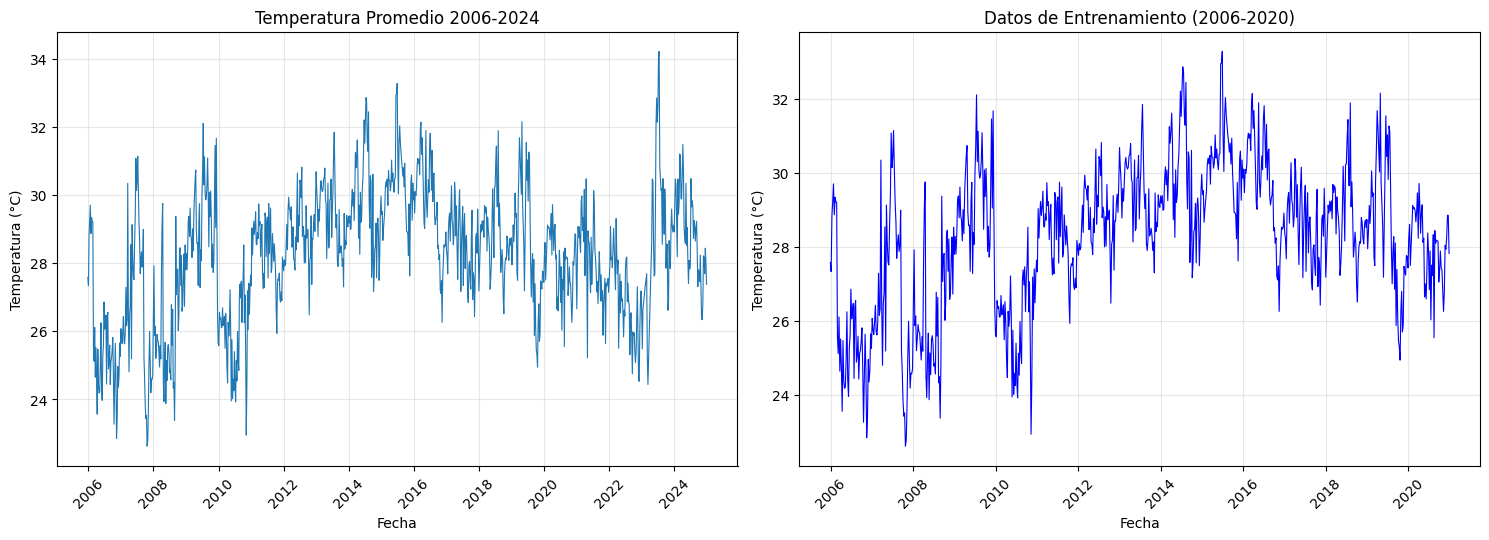

In [ ]:
# ============================================
# 4. VISUALIZAR DATOS ORIGINALES
# ============================================

plt.figure(figsize=(15, 10))

# Gráfico 1: Serie completa
plt.subplot(2, 2, 1)
plt.plot(df_semanal.index, df_semanal['Temperatura'], linewidth=0.8)
plt.title('Temperatura Promedio 2006-2024')
plt.ylabel('Temperatura (°C)')
plt.xlabel('Fecha')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Gráfico 2: Serie de entrenamiento
plt.subplot(2, 2, 2)
plt.plot(train_df.index, train_df['Temperatura'], linewidth=0.8, color='blue')
plt.title('Datos de Entrenamiento (2006-2020)')
plt.ylabel('Temperatura (°C)')
plt.xlabel('Fecha')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

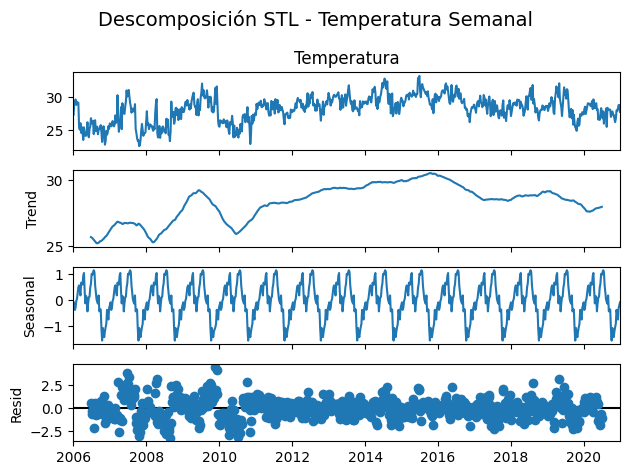

In [ ]:
# ============================================
# 5. DESCOMPOSICIÓN ESTACIONAL
# ============================================

from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición STL (equivalente a stl() en R)
decomposition = seasonal_decompose(train_df['Temperatura'],
                                  model='additive',
                                  period=52)

plt.figure(figsize=(12, 8))
decomposition.plot()
plt.suptitle('Descomposición STL - Temperatura Semanal', fontsize=14)
plt.tight_layout()
plt.show()

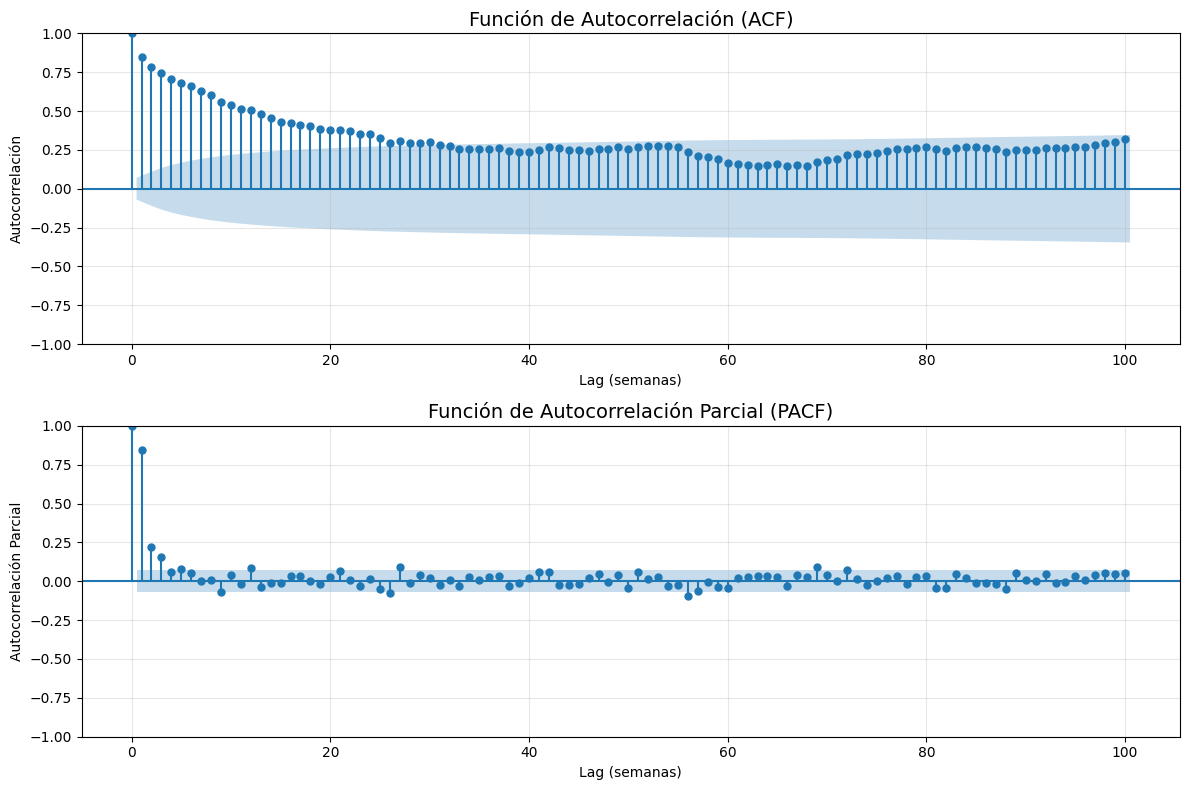

In [ ]:
# ============================================
# 6. AUTOCORRELACIÓN (ACF y PACF)
# ============================================

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ACF
plot_acf(train_df['Temperatura'], lags=100, ax=axes[0], alpha=0.05)
axes[0].set_title('Función de Autocorrelación (ACF)', fontsize=14)
axes[0].set_xlabel('Lag (semanas)')
axes[0].set_ylabel('Autocorrelación')
axes[0].grid(True, alpha=0.3)

# PACF
plot_pacf(train_df['Temperatura'], lags=100, ax=axes[1], alpha=0.05)
axes[1].set_title('Función de Autocorrelación Parcial (PACF)', fontsize=14)
axes[1].set_xlabel('Lag (semanas)')
axes[1].set_ylabel('Autocorrelación Parcial')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================
# 7. PRUEBAS DE ESTACIONARIEDAD
# ============================================

from statsmodels.tsa.stattools import  kpss

# Prueba KPSS
def test_estacionariedad_kpss(serie):
    result = kpss(serie.dropna(), regression='c', nlags='auto')
    print('\nPrueba KPSS:')
    print(f'  Estadístico KPSS: {result[0]:.4f}')
    print(f'  p-value: {result[1]:.4f}')
    print(f'  Lags usados: {result[2]}')
    if result[1] > 0.05:
        print('  Conclusión: La serie ES estacionaria (no rechaza H0)')
    else:
        print('  Conclusión: La serie NO es estacionaria (rechaza H0)')
    return result

print("=" * 60)
print("PRUEBA DE ESTACIONARIEDAD")
print("=" * 60)
result_kpss = test_estacionariedad_kpss(train_df['Temperatura'])


PRUEBA DE ESTACIONARIEDAD

Prueba KPSS:
  Estadístico KPSS: 1.5334
  p-value: 0.0100
  Lags usados: 17
  Conclusión: La serie NO es estacionaria (rechaza H0)


In [ ]:
# ============================================
# 8. DIFERENCIACIÓN
# ============================================

#!pip install pmdarima


# Calcular número de diferencias necesarias
from pmdarima.arima import ndiffs


n_diffs_kpss = ndiffs(train_df['Temperatura'], test='kpss')
print(f"Número de diferencias necesarias (prueba KPSS): {n_diffs_kpss}")

# Aplicar diferenciación
if n_diffs > 0:
    serie_diff = train_df['Temperatura'].diff(n_diffs).dropna()

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(train_df['Temperatura'], label='Original', linewidth=1)
    plt.title('Serie Original')
    plt.ylabel('Temperatura (°C)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 1, 2)
    plt.plot(serie_diff.index, serie_diff.values, label='Diferenciada',
             linewidth=1, color='green')
    plt.title(f'Serie Diferenciada (d={n_diffs})')
    plt.ylabel('Diferencia')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Número de diferencias necesarias (prueba KPSS): 1


In [ ]:
# ============================================
# 9. MODELO SARIMA(1,1,1)(1,1,1)[52]
# ============================================

from statsmodels.tsa.statespace.sarimax import SARIMAX

print("\n" + "=" * 60)
print("AJUSTANDO MODELO SARIMA(1,1,1)(1,1,1)[52]")
print("=" * 60)

# Ajustar modelo SARIMA
modelo_sarima = SARIMAX(train_df['Temperatura'],
                       order=(1, 1, 1),           # (p,d,q)
                       seasonal_order=(1, 1, 1, 52),  # (P,D,Q,s)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

resultado = modelo_sarima.fit(disp=False)

# Resumen del modelo
print("\nRESUMEN DEL MODELO SARIMA:")
print(resultado.summary())



AJUSTANDO MODELO SARIMA(1,1,1)(1,1,1)[52]

RESUMEN DEL MODELO SARIMA:
                                     SARIMAX Results                                      
Dep. Variable:                        Temperatura   No. Observations:                  783
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -992.353
Date:                            Thu, 04 Dec 2025   AIC                           1994.705
Time:                                    20:46:36   BIC                           2017.286
Sample:                                         0   HQIC                          2003.448
                                            - 783                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3621      0.055      6.606

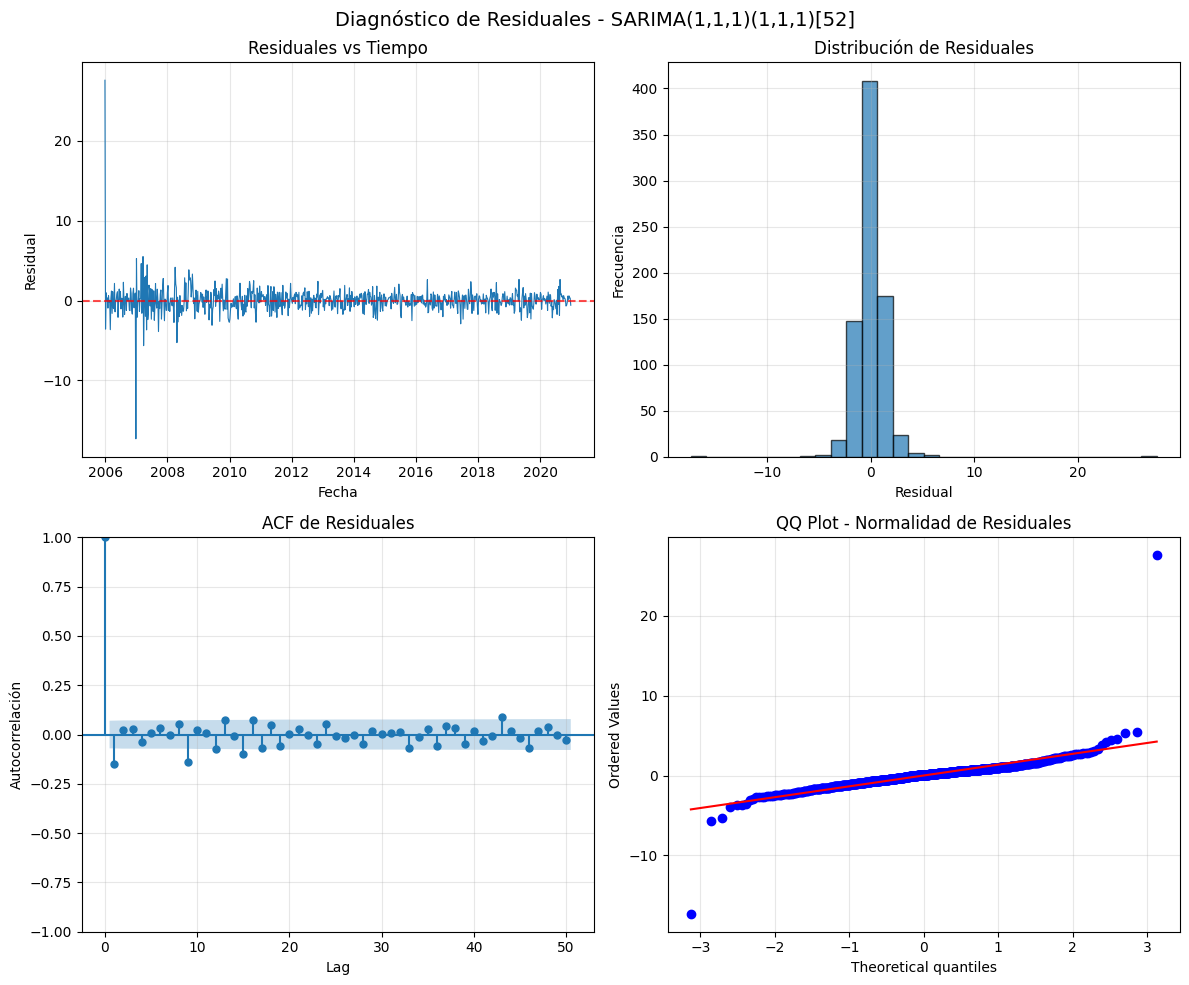

In [ ]:
# ============================================
# 10. DIAGNÓSTICO DE RESIDUALES
# ============================================

residuales = resultado.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Residuales vs tiempo
axes[0, 0].plot(residuales.index, residuales.values, linewidth=0.8)
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.7)
axes[0, 0].set_title('Residuales vs Tiempo')
axes[0, 0].set_xlabel('Fecha')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid(True, alpha=0.3)

# Histograma de residuales
axes[0, 1].hist(residuales, bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribución de Residuales')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].grid(True, alpha=0.3)

# ACF de residuales
plot_acf(residuales, lags=50, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('ACF de Residuales')
axes[1, 0].set_xlabel('Lag')
axes[1, 0].set_ylabel('Autocorrelación')
axes[1, 0].grid(True, alpha=0.3)

# QQ plot
from scipy import stats
stats.probplot(residuales.dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('QQ Plot - Normalidad de Residuales')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Diagnóstico de Residuales - SARIMA(1,1,1)(1,1,1)[52]', fontsize=14)
plt.tight_layout()
plt.show()



In [ ]:
# ============================================
# 11. PRONÓSTICO
# ============================================

# Pronosticar para el período de prueba
n_pronosticos = len(test_df)
pronostico = resultado.get_forecast(steps=n_pronosticos)

# Obtener predicciones e intervalos de confianza
pred_mean = pronostico.predicted_mean
pred_ci = pronostico.conf_int(alpha=0.05)  # 95% intervalo de confianza

# Crear DataFrame con resultados
df_predicciones = pd.DataFrame({
    'Fecha': test_df.index,
    'Real': test_df['Temperatura'].values,
    'Predicho': pred_mean.values,
    'Lo95': pred_ci.iloc[:, 0].values,
    'Hi95': pred_ci.iloc[:, 1].values
})

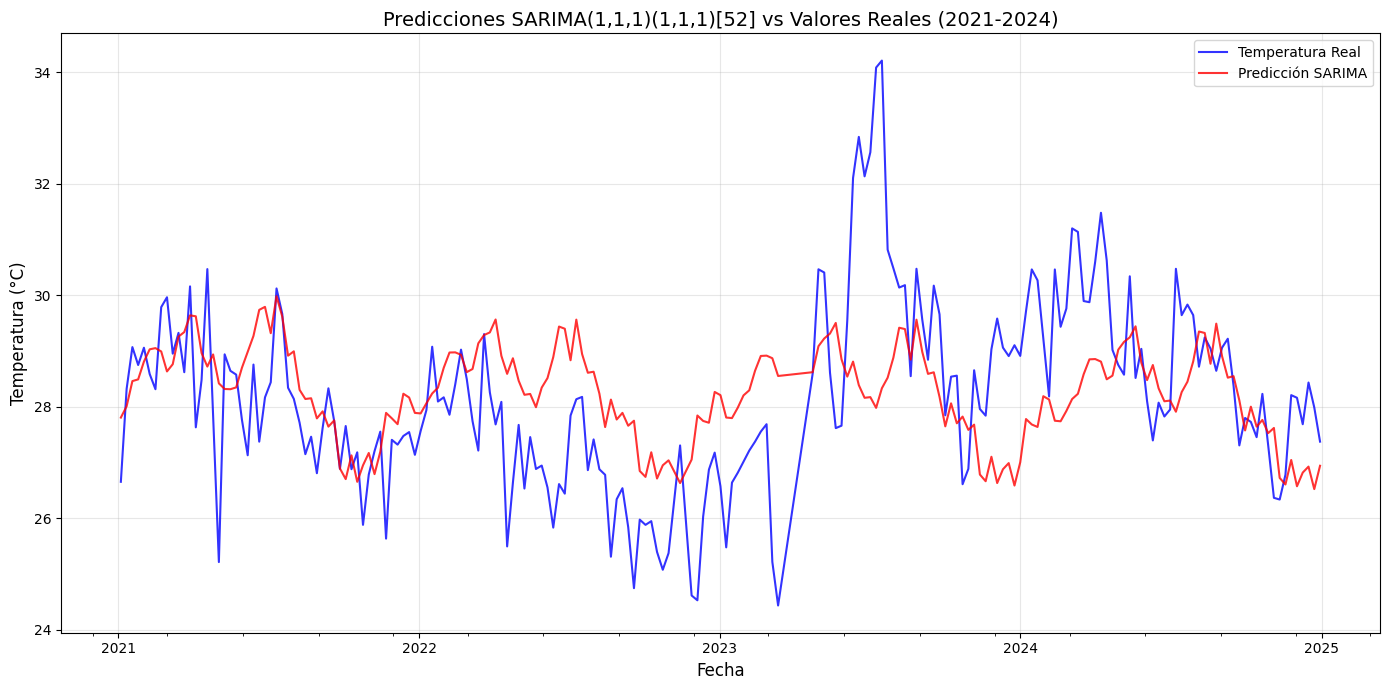

In [ ]:
# ============================================
# 12. GRÁFICO DE PREDICCIONES (ZOOM 2021-2024)
# ============================================

plt.figure(figsize=(14, 7))

# Gráfico de predicciones vs reales
plt.plot(df_predicciones['Fecha'], df_predicciones['Real'],
         label='Temperatura Real', linewidth=1.5, color='blue', alpha=0.8)
plt.plot(df_predicciones['Fecha'], df_predicciones['Predicho'],
         label='Predicción SARIMA', linewidth=1.5, color='red', alpha=0.8)

plt.title('Predicciones SARIMA(1,1,1)(1,1,1)[52] vs Valores Reales (2021-2024)', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.xlabel('Fecha', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Formatear eje x
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(plt.matplotlib.dates.MonthLocator(interval=3))

plt.tight_layout()
plt.show()

In [ ]:
# ============================================
# 13. CÁLCULO DE MÉTRICAS DE ERROR
# ============================================

def calcular_metricas(real, pred):
    """
    Calcula métricas de error para series temporales

    Parámetros:
    real : array-like, valores reales
    pred : array-like, valores predichos

    Retorna:
    DataFrame con métricas
    """
    real = np.array(real)
    pred = np.array(pred)

    # Filtrar valores no nulos
    mask = ~(np.isnan(real) | np.isnan(pred))
    real = real[mask]
    pred = pred[mask]

    if len(real) == 0:
        return pd.DataFrame()

    # Calcular errores
    errores = real - pred

    # Métricas
    mae = np.mean(np.abs(errores))
    mse = np.mean(errores**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(errores / real)) * 100

    # MASE (Mean Absolute Scaled Error)
    # Error naive: diferencia con valor anterior
    if len(real) > 1:
        naive_error = np.mean(np.abs(np.diff(real)))
        mase = mae / naive_error if naive_error > 0 else np.nan
    else:
        mase = np.nan

    # Crear DataFrame con resultados
    metricas = pd.DataFrame({
        'Métrica': ['RMSE', 'MAE', 'MAPE', 'MASE'],
        'Valor': [rmse, mae, mape, mase],
        'Unidad': ['°C', '°C', '%', 'adimensional']
    })

    return metricas

# Calcular métricas
metricas = calcular_metricas(df_predicciones['Real'], df_predicciones['Predicho'])

print("\n" + "=" * 60)
print("MÉTRICAS DE ERROR - SARIMA(1,1,1)(1,1,1)[52]")
print("=" * 60)
print(metricas.to_string(index=False))


MÉTRICAS DE ERROR - SARIMA(1,1,1)(1,1,1)[52]
Métrica    Valor       Unidad
   RMSE 1.623385           °C
    MAE 1.244406           °C
   MAPE 4.405506            %
   MASE 1.483648 adimensional
